In [1]:
import scipy.io as sio


mat = sio.loadmat('./2Dcurves_multi_long3_positions_Tracks_ds.mat')

print(mat.keys())

print(len(mat['Tracks_ds']))

dict_keys(['__header__', '__version__', '__globals__', 'MyMedia', 'Tracks_ds'])
2089


In [2]:
import torch
import numpy as np

length = 20

offset = 0.1*np.random.randn(len(mat['Tracks_ds']))

A = torch.stack([torch.tensor(np.stack([np.interp(np.linspace(0+offset[i],1+offset[i],length), np.linspace(0,1,mat['Tracks_ds'][i][0].shape[0]),mat['Tracks_ds'][i][0][:,0]), np.interp(np.linspace(0+offset[i],1+offset[i],length), np.linspace(0,1,mat['Tracks_ds'][i][0].shape[0]),mat['Tracks_ds'][i][0][:,2])]) ).T for i in range(len(mat['Tracks_ds']))])

print(A.shape)

/home/tbertrand/anaconda3/envs/landmarkv2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2089, 20, 2])


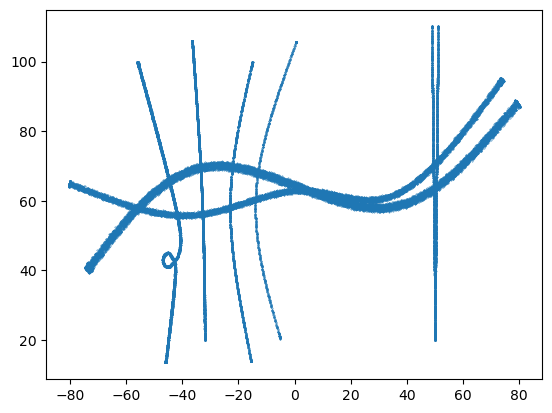

In [3]:
points = A.reshape([-1,2])


import matplotlib.pyplot as plt
plt.scatter(points[:,0], points[:,1], s=.1)

In [4]:
tracks_downsampled = (A[::20,:,:]-torch.tensor([A[...,0].min(),A[...,1].min()]))/(torch.tensor([A[...,0].max(),A[...,1].max()])-torch.tensor([A[...,0].min(),A[...,1].min()]))


print(tracks_downsampled.shape)

sigma = 0.005

N = 512
[X,Y] = torch.meshgrid(torch.linspace(0,1,N), torch.linspace(0,1,N))
acquisition = torch.exp(-((X[None,None,:,:]-tracks_downsampled[:,:,0][:,:,None,None])**2+(Y[None,None,:,:]-tracks_downsampled[:,:,1][:,:,None,None])**2)/sigma**2).sum(dim=0)
# plt.scatter(points_downsampled[:,1], points_downsampled[:,0], s=1)

torch.Size([105, 20, 2])


/home/tbertrand/anaconda3/envs/landmarkv2/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([20, 512, 512])


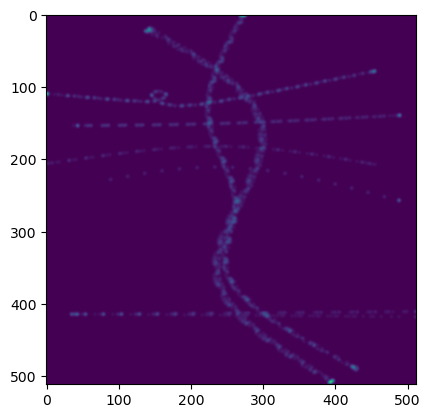

In [5]:
print(acquisition.shape)

plt.imshow((acquisition.mean(dim=0)))

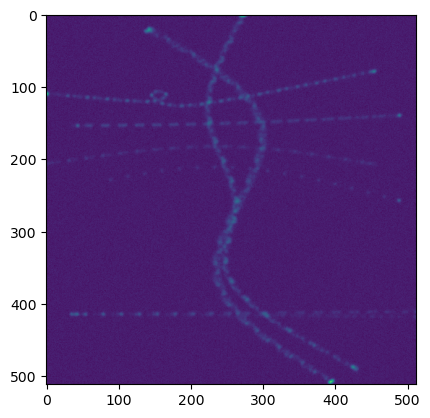

In [6]:


acquisition_noised = acquisition + .1*torch.randn(acquisition.shape)

plt.imshow(acquisition_noised.mean(dim=0))

In [7]:
import napari

napari.view_image(acquisition_noised.numpy())

print(list(acquisition_noised))

[tensor([[-0.1027, -0.0990,  0.0959,  ...,  0.1245,  0.0193, -0.0114],
        [ 0.2019,  0.1984,  0.0665,  ..., -0.0381,  0.2633,  0.0309],
        [ 0.2920, -0.0338, -0.0577,  ..., -0.0484,  0.1872, -0.1196],
        ...,
        [-0.0693,  0.0595,  0.1101,  ...,  0.1358,  0.0237,  0.1543],
        [-0.1764,  0.0139,  0.0024,  ...,  0.0500, -0.1097, -0.0430],
        [ 0.0627,  0.0105,  0.0732,  ...,  0.0245,  0.1080, -0.0124]],
       dtype=torch.float64), tensor([[ 0.0847, -0.0967,  0.0397,  ...,  0.0736,  0.0697, -0.0348],
        [ 0.1288,  0.0482, -0.0149,  ..., -0.1322, -0.1610,  0.0154],
        [ 0.1681,  0.0319,  0.0889,  ...,  0.0786,  0.0078,  0.0560],
        ...,
        [ 0.1222,  0.0135, -0.1366,  ..., -0.0490,  0.1063,  0.0147],
        [ 0.0991,  0.0405,  0.0758,  ..., -0.0602, -0.0541, -0.0484],
        [ 0.1430,  0.0291,  0.1188,  ...,  0.0132, -0.0719,  0.0722]],
       dtype=torch.float64), tensor([[-0.1432,  0.1502,  0.1777,  ...,  0.0653, -0.0818, -0.0341],
   

In [ ]:
#CREATE GIF FROM DATA  
from PIL import Image

list_acquisition = (list(acquisition_noised))

list_acquisition = [Image.fromarray(255*x.numpy()) for x in list_acquisition]

list_acquisition[0].save('./acquisition_noised.gif', save_all=True, append_images=list_acquisition[1:], duration=100, loop=0)